In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import print_function, absolute_import, division

In [3]:
import numpy as np
from GomokuBoard import GomokuBoard
from HeuristicPolicy import Move, StochasticMaxSampler, HeuristicGomokuPolicy
from Heuristics import Heuristics
from GomokuTools import GomokuTools as gt

In [4]:
A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U = \
    1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
BLACK=0
WHITE=1
EDGES=2

## A sampler
This class allows to sample from the top n of an array of scores, 
with higher probability for the larger scores. With bias > 1.0,
the sampler has an even higher bias toward the larger scores.


In [5]:
sample = np.random.randint(0, 100, [8,8])/20.0
enumerated = list(np.ndenumerate(sample))
sampler = StochasticMaxSampler(enumerated, 10, bias=5)
sampler.choices

[(0.5465444797909781, (1, 7), 0.453455520209022, 4.95),
 (0.4166272980883604, (7, 7), 0.12991718170261768, 4.7),
 (0.28671011638574273, (6, 2), 0.12991718170261768, 4.7),
 (0.185530513541314, (7, 1), 0.10117960284442871, 4.65),
 (0.10673175961521944, (6, 6), 0.07879875392609456, 4.6),
 (0.06950986386286256, (6, 5), 0.03722189575235688, 4.45),
 (0.04693364287643073, (4, 4), 0.02257622098643183, 4.35),
 (0.0243574218899989, (4, 3), 0.02257622098643183, 4.35),
 (0.010664251681280181, (4, 0), 0.01369317020871872, 4.25),
 (0.0, (2, 3), 0.010664251681280181, 4.2)]

In [6]:
print([sampler.draw() for i in range(10)])

[(6, 5), (6, 6), (1, 7), (4, 3), (7, 7), (1, 7), (1, 7), (6, 2), (1, 7), (6, 6)]


## Use a policy to play a bit

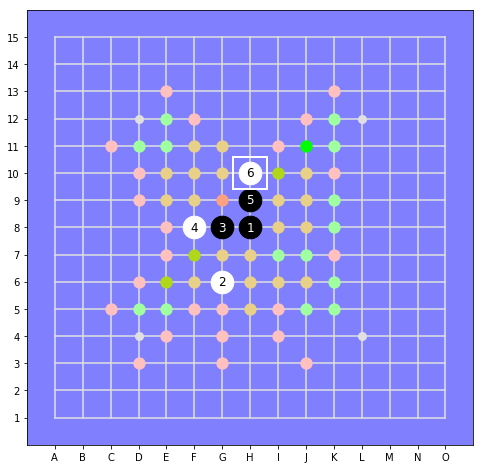

In [7]:
h = Heuristics(kappa=3.0)
board = GomokuBoard(h, N=15, disp_width=8)
p = HeuristicGomokuPolicy(board, 2)
board.set(H,8).set('G',6).set(G,8).set(F,8).set(H,9).set(H,10)
board.display('current');

Win-in-2: (H, 7)
GAME OVER!


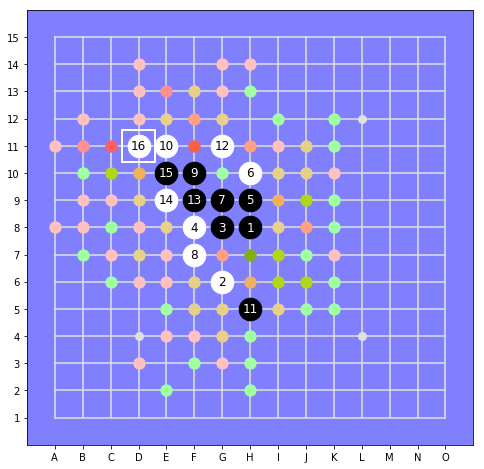

In [19]:
move = p.suggest(bias=.2, topn=5)
print(move)
if move.status == 0:
    board.set(move.x, move.y) 
    print("Value after the move: %s" % board.get_value())
else:
    print("GAME OVER!")
board.display('current')

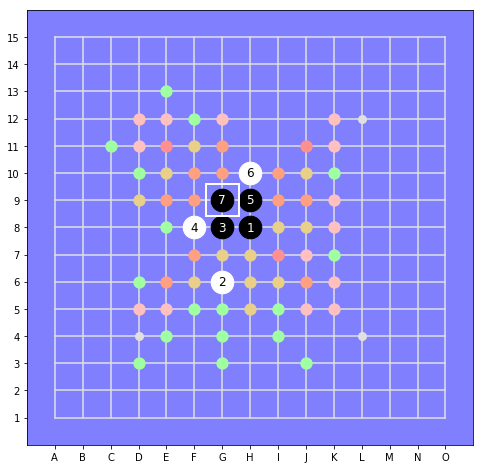

In [9]:
board.display("current")

In [145]:
p.suggest()

Defending Win-in-2: (J, 11)

In [147]:
board.getnh(J,11)

|                 |
|                 |
|                 |
|                 |
|        *        |
|      x          |
|    x            |
|  x              |
|                 |

In [138]:
board.current_color

0

In [148]:
rc = gt.b2m((J,11),15)

In [150]:
color = BLACK
options=[]
for direction in ['e', 'ne', 'n', 'nw']:
    step = np.array(gt.dirs()[direction][1])
    for w in [-4,-3,-2,-1,1,2,3,4]:
        r, c = rc+w*step
        if r >= 0 and r < 15 and c >= 0 and c < 15:
            x,y = gt.m2b((r,c), 15)
            if (x,y) not in board.stones:
                    board.set(x,y)
                    board.compute_scores(color)
                    s=board.get_score(color, J,11)
                    board.undo()
                    board.compute_scores(color)
                    if s < 7:
                        options.append((x,y))
options


[(6, 7), (11, 12)]

In [182]:
l = [list(zip(options, np.zeros(len(options))))[0]]
sampler = StochasticMaxSampler(l, len(options))

In [197]:
sampler.draw()

(6, 7)

In [184]:
color = BLACK
print(board.get_score(0,E,11))
for move in options:
    print(move, s)

4.999999999999999
(6, 7) 7.0
(11, 12) 7.0


In [32]:
rc + step * 3

array([4, 7])